### Цель:

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.


### Шаги по выполнению проекта

1. Загрузка и подготовка данных.
2. Векторизация текстов.
2. Обучение разныех модели. 
3. Выводы.


### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import torch
import transformers
from tqdm import notebook

import transformers

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import SnowballStemmer

from pymystem3 import Mystem

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Посмотрим максимальную длину строки.

In [6]:
df['len'] = df['text'].apply(lambda x: len(x))
df['len'].max()

5000

Посмотрим на соотношение положительных и отрицательных значений целевого признака.

In [7]:
df['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

У нас сильный дисбаланс целевых признаков. При плохом качестве модели можно будет попробовать сделать upsampling.

Для обучения моделей следует векторизировать текст. Попробуем два способа векторизации: TF-IDF из библиотеки sklearn и модель BERT.

## TF-IDF

Для начала лемматизируем тексты.

Создадим объект лемматизатора:

In [9]:
stemmer = SnowballStemmer('english')

Напишем функцию, которая сначала токенизирует текст, а затем лемматизирует его.

In [80]:
def stem_text(text):
    # токенизируем текст:
    tokenized = nltk.word_tokenize(text)
    
    # лемматизируем каждое слово
    lemmatize = []
    for word in tokenized:
        stem_word = stemmer.stem(word)
        lemmatize.append(stem_word)
    
    # собираем лемматизированные слова в строку
    lemmatize = ' '.join(lemmatize)
    return lemmatize

In [37]:
%%time
df['lemm_text'] = df['text'].apply(stem_text)

CPU times: user 4min 59s, sys: 84 ms, total: 4min 59s
Wall time: 5min


In [38]:
df

,text,toxic,len,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,264,explan whi the edit made under my usernam hard...
1,D'aww! He matches this background colour I'm s...,0,112,d'aww ! he match this background colour i 'm s...
2,"Hey man, I'm really not trying to edit war. It...",0,233,"hey man , i 'm realli not tri to edit war . it..."
3,"""\nMore\nI can't make any real suggestions on ...",0,622,`` more i ca n't make ani real suggest on impr...
4,"You, sir, are my hero. Any chance you remember...",0,67,"you , sir , are my hero . ani chanc you rememb..."
...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,295,"`` : : : : : and for the second time of ask , ..."
159567,You should be ashamed of yourself \n\nThat is ...,0,99,you should be asham of yourself that is a horr...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,81,"spitzer umm , there no actual articl for prost..."
159569,And it looks like it was actually you who put ...,0,116,and it look like it was actual you who put on ...


Очистим текст от лишних символов. Оставим только английский буквы. Для этого напишем функцию clear_text

In [39]:
def clear_text(text):
    new_text = re.sub(r'[^a-zA-Z\' ]', '', text)
    return new_text

Создадим столбец с текстом, очищенным от лишних символов.

In [40]:
%%time
df['clear_text'] = df['lemm_text'].apply(clear_text)

CPU times: user 1.52 s, sys: 8 ms, total: 1.53 s
Wall time: 1.54 s


Посчитаем длину получившихся строк (она нам понадобиться в дальнейшем при подготовке данных для модели BERT).

In [41]:
df['clear_len'] = df['clear_text'].apply(lambda x: len(x))

In [42]:
df

,text,toxic,len,lemm_text,clear_text,clear_len
0,Explanation\nWhy the edits made under my usern...,0,264,explan whi the edit made under my usernam hard...,explan whi the edit made under my usernam hard...,231
1,D'aww! He matches this background colour I'm s...,0,112,d'aww ! he match this background colour i 'm s...,d'aww he match this background colour i 'm se...,93
2,"Hey man, I'm really not trying to edit war. It...",0,233,"hey man , i 'm realli not tri to edit war . it...",hey man i 'm realli not tri to edit war it '...,210
3,"""\nMore\nI can't make any real suggestions on ...",0,622,`` more i ca n't make ani real suggest on impr...,more i ca n't make ani real suggest on improv...,556
4,"You, sir, are my hero. Any chance you remember...",0,67,"you , sir , are my hero . ani chanc you rememb...",you sir are my hero ani chanc you rememb wh...,65
...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,295,"`` : : : : : and for the second time of ask , ...",and for the second time of ask when you...,270
159567,You should be ashamed of yourself \n\nThat is ...,0,99,you should be asham of yourself that is a horr...,you should be asham of yourself that is a horr...,81
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,81,"spitzer umm , there no actual articl for prost...",spitzer umm there no actual articl for prosti...,72
159569,And it looks like it was actually you who put ...,0,116,and it look like it was actual you who put on ...,and it look like it was actual you who put on ...,111


Создадим обучающие и целевые признаки

In [43]:
features = df['clear_text']
target = df['toxic']

Создадим обучающую и тестовую выборки

In [44]:
(features_train,
 features_test,
 target_train,
 target_test) = train_test_split(features, target, test_size=0.2, random_state=12)

Проверим соотношение положительных и отрицательных ответов в обучающей и тестовой выборках:

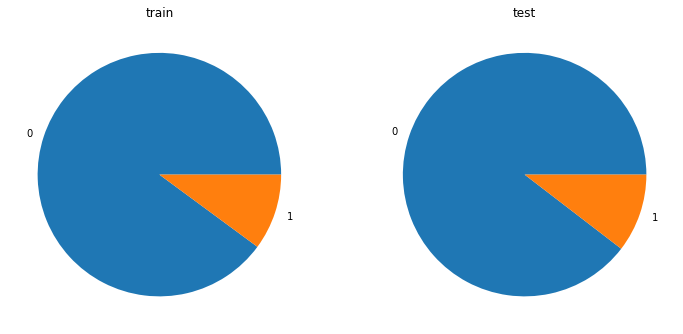

In [45]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.pie(target_train.value_counts(), labels=target_train.value_counts().index)
plt.title('train')

plt.subplot(122)
plt.pie(target_test.value_counts(), labels=target_train.value_counts().index)
plt.title('test');

соотношение положительных и отрицательных ответов в обучающей и тестовой выборках примерно одинаковое.

Векторизируем текст. При векторизации уберем из текста стоп-слова.

In [46]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Помимо стоп-слов исключим из текстов слишком редкие и слишком частые слова.

In [47]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.99)

Векторизируем обучающую выборку

In [48]:
%%time
features_train = count_tf_idf.fit_transform(features_train)

CPU times: user 8.34 s, sys: 144 ms, total: 8.48 s
Wall time: 8.49 s


In [49]:
features_train.shape

(127656, 21974)

Векторизируем тестовую выборку

In [50]:
features_test = count_tf_idf.transform(features_test)

In [51]:
target_train.value_counts()

0    114756
1     12900
Name: toxic, dtype: int64

In [52]:
features_test.shape

(31915, 21974)

# 2. Обучение

Обучим несколько разных моделей и посмотрим на метрику f1.

**Логистическая регрессия**

In [53]:
%%time
model_lr = LogisticRegressionCV(class_weight='balanced', 
                                cv=2,
                                random_state=12,
                                scoring='f1').fit(features_train, target_train)

CPU times: user 3min 9s, sys: 2min 4s, total: 5min 14s
Wall time: 5min 17s


Посмотрим среднее значение f1, которую показала логистическая регрессия.

In [54]:
lr_scores = []
for i in model_lr.scores_[1]:
    lr_scores.append(i.mean())
lr_scores = np.array(lr_scores).mean()
lr_scores

0.7032598430811878

Для остальных моделей напишем функцию для подобора гиперпараметров.

In [55]:
def search_best_params(model, param_grid):
    grid = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        scoring='f1',
                        cv=3)
    grid.fit(features_train, target_train)
    print('Лучшие параметры: {}'.format(grid.best_params_))
    print('F1: {:.2f}'.format(grid.best_score_))
    return grid

Подберем гиперпараметры и протестируем еще несколько моделей.

**AdaBoost:**

In [56]:
%%time
model_abc = AdaBoostClassifier(random_state=12)
param_abc = {'learning_rate' : [1.0, 0.5]}
model_abc = search_best_params(model_abc, param_abc)

Лучшие параметры: {'learning_rate': 1.0}
F1: 0.69
CPU times: user 3min 54s, sys: 524 ms, total: 3min 55s
Wall time: 3min 56s


**Random Forest:**

In [57]:
%%time

model_rfc = RandomForestClassifier(class_weight='balanced', random_state=12)

params_rfc = {'max_depth' : [100, 200]}

model_rfc = search_best_params(model_rfc, params_rfc)

Лучшие параметры: {'max_depth': 200}
F1: 0.62
CPU times: user 1min 55s, sys: 0 ns, total: 1min 55s
Wall time: 1min 56s


**Light GBM:**

In [58]:
%%time

model_lgb = lgb.LGBMClassifier(random_state=12, n_estimators=30)

params_lgb = {'max_depth' : [100, 200]}

model_lgb = search_best_params(model_lgb, params_lgb)

Лучшие параметры: {'max_depth': 100}
F1: 0.69
CPU times: user 4min 45s, sys: 808 ms, total: 4min 46s
Wall time: 4min 49s


Сведем полученные результаты в таблицу.

In [59]:
result = pd.DataFrame(data=[['LogisticRegressionCV', lr_scores],
                           ['AdaBoost', model_abc.best_score_],
                           ['RandomForest', model_rfc.best_score_],
                           ['LGBClassifier', model_lgb.best_score_]],
                      columns=['Model', 'f1_score'])
result.sort_values('f1_score', ascending=False)

,Model,f1_score
0,LogisticRegressionCV,0.703260
3,LGBClassifier,0.690652
1,AdaBoost,0.686777
2,RandomForest,0.623598


## Тестирование модели

Лучший результат показала логистическая регрессия. Проверим качество модели на тестовой выборке.

In [60]:
print('F1 = {:.2f}'.format(f1_score(model_lr.predict(features_test), target_test)))

F1 = 0.76


## Векторизация через BERT

Попробуем векторизировать текст с использованием модели BERT. Поскольку она очень требовательна к ресурсам, протстируем ее на небольшой выборке.

Для начала уберем из нашего датафрейма все записи длинне 512 символов.

In [61]:
df_bert = df[df['len'] < 512]

Сделаем сэмпл в 500 записей.

In [62]:
df_bert = df_bert.sample(n=500, random_state=12)

In [63]:
df_bert['toxic'].value_counts(normalize=True)

0    0.872
1    0.128
Name: toxic, dtype: float64

Создадим целевой признак:

In [64]:
target_bert = df_bert['toxic']

Токенизируем наши тексты. Для этого инициализируем токенайзер

In [65]:
tokenizer = transformers.BertTokenizer(vocab_file='vocab.txt')

Перобразуем текст в токены.

In [66]:
%%time
tokenized = df_bert['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

CPU times: user 484 ms, sys: 0 ns, total: 484 ms
Wall time: 488 ms


Выровняем длины векторов. Для этого определим максимальную длину векторов.

In [67]:
max_len = pd.Series(len(x) for x in tokenized).max()
max_len

195

In [68]:
%%time
padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.9 ms


Создадим маску для значимых токенов:

In [69]:
attention_mask = np.where(padded != 0, 1, 0)

Инициализируем модель:

In [70]:
config = transformers.BertConfig.from_json_file('bert_config.json')

In [71]:
model_bert = transformers.BertModel.from_pretrained('pytorch_model.bin', config=config)

Преобразуем текст в эмбеддинги. Для этого сделаем цикл по батчам.

In [72]:
%%time

batch_size = 50
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i : batch_size * (i + 1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i : batch_size * (i + 1)])
    
    with torch.no_grad():
        batch_embeddings = model_bert(batch, attention_mask = attention_mask_batch)
    embeddings.append(batch_embeddings[0][:, 0, :].numpy())

features_bert = np.concatenate(embeddings)


CPU times: user 10min 24s, sys: 1min 7s, total: 11min 31s
Wall time: 11min 33s


Создадим обучающую и тестовую выборки:

In [73]:
(bert_features_train,
 bert_features_test,
 bert_target_train,
 bert_target_test) = train_test_split(features_bert, target_bert, test_size=0.2)

Обучим модель логистической регрессии

In [74]:
%%time
lr_bert = LogisticRegressionCV(class_weight='balanced', 
                               cv=2,
                               random_state=12,
                               scoring='f1').fit(bert_features_train, bert_target_train)

CPU times: user 3.24 s, sys: 4 s, total: 7.24 s
Wall time: 7.2 s


In [75]:
bert_scores = []
for i in lr_bert.scores_[1]:
    bert_scores.append(i.mean())
bert_scores = np.array(bert_scores).mean()
bert_scores

0.5706417786587057

In [76]:
print('F1 = {:.2f}'.format(f1_score(lr_bert.predict(bert_features_test), bert_target_test)))

F1 = 0.69


# 3. Выводы

Подготовлена модель предсказания тональной окраски текста комментариев.


Подготовка эбеддингов выполнена с использованием TF-IDF.


Для предсказания тональной окраски текста протестировано несколько моделей: LogisticRegressionCV, AdaBoost, RandomForest, LGBClassifier. Модели обучались на обучающей выборки с использованием кросс-валидации (cv=3).


Лучшую метрику на кросс-валидации показала модель LogisticRegressionCV с f1 = 0.7.


На тестовой выборке модель показала f1 = 0.76.


Дя экономии времени обучения на небольшой выборке (500 объектов) протестирована векторизация текста с использованием BERT. Модель LogisticRegressionCV на тестовой выборке показала f1 = 0.69. Неплохой результат, учитывая небольшую обучающую выборку. При обучении на полном датасете вектоизация с помощью BERT скорее всего показала бы лучшие результаты.